Denoising fMRI data and functional connectivity estimation using aCompCor
===============================================

This is test script for denoising and FC estimation from fMRI data (1 subject) preprocessed in fmriprep.

**Method**: aCompCor with regressing out 24 motion parameters

Step 1: Importing packages
-------------------------------------------

In [1]:
%reset
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import preprocessing # for normalization of confounds columns

from nilearn import datasets # for fetching atlas
from nilearn import plotting 
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

from denoise import *


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Step 2: Creating atlas
-------------------------------------------

In [2]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    smoothing_fwhm = 6, 
    radius = 5,
    detrend = True, 
    standardize = True,
    low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 2
)

Step 3: Loading data
-----------------------

In [3]:
# Loading functional data
top_dir = '/home/finc/Downloads/fmriprep/'

sub = 'sub-01'
ses = 'ses-1'
task = 'dualnback'

sub_dir = top_dir + sub + '/' + ses + '/func/'

suffix = 'space-MNI152NLin2009cAsym_preproc.nii.gz'
#suffix = 'space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz'

dual_data = sub_dir + sub + '_' + ses + '_task-' + task + '_bold_' + suffix


Step 4: Confound preprocessing
-----------------------------------

In [7]:
# Loading confound data
confounds_path = sub_dir + sub + '_' + ses + '_task-' + task + '_bold_confounds.tsv'
confounds = pd.read_csv(confounds_path, delimiter = '\t')

# Select columns of interest
confounds_motion = confounds[confounds.filter(regex='X|Y|Z|RotX|RotY|RotZ').columns]
confounds_anat = confounds[confounds.filter(regex='CSF|WhiteMatter|aCompCor|Cos').columns]
confounds_fd =  confounds[confounds.filter(regex='Framewise').columns]

# Calculate 24 fristom motion parameters
confounds_motion_24 =  motion_24_friston(confounds_motion)

# Detect outliers 
confounds_scrub = scrubbing(confounds_fd, before = False)

# Concatenate dataframes
#confounds_clean = pd.concat([confounds_anat, ], axis = 1)

# Standardize confounds
confounds_anat = standardize(confounds_anat)

# Add scrubbing columns
confounds_clean = pd.concat([confounds_anat, confounds_motion_24, confounds_scrub], axis = 1)

# Save preprocessed confound file
confounds_clean.to_csv(sub_dir + 'confounds_' + task + '_clean_acompcor.csv', sep = ',', index = False)
confounds_clean_path = sub_dir + 'confounds_' + task + '_clean_acompcor.csv'

confounds_clean.head()

/home/finc/Dropbox/GitHub/Denoising/denoise.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_td'] = temp_diff
/home/finc/Dropbox/GitHub/Denoising/denoise.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_sqrt'] = sqrt
/home/finc/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

,CSF,WhiteMatter,aCompCor00,aCompCor01,aCompCor02,aCompCor03,aCompCor04,aCompCor05,Cosine00,Cosine01,...,RotY_sqrt,RotZ_sqrt,X_td_sqrt,Y_td_sqrt,Z_td_sqrt,RotX_td_sqrt,RotY_td_sqrt,RotZ_td_sqrt,scrubbing,scrubbing_aft
0,1.514890,1.670018,-0.212445,-0.279174,1.434394,-0.577496,0.320911,-0.950788,1.414198,1.414153,...,9.180303e-07,1.678346e-08,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0,0
1,1.335976,0.339101,-1.277477,-0.415930,-0.239572,0.603783,0.261672,-0.055013,1.414078,1.413670,...,8.201258e-07,3.621368e-09,0.001574,0.000241,0.001447,1.436043e-06,9.180303e-07,1.678346e-08,0,0
2,1.215602,0.767958,-1.102417,-0.350196,-0.213752,0.125815,-1.444943,1.110857,1.413836,1.412705,...,1.151222e-06,1.347805e-08,0.001622,0.000208,0.011114,8.917082e-07,8.201258e-07,3.621368e-09,0,0
3,2.375021,1.773731,-0.388581,-0.277538,0.177998,-0.664507,-0.618556,1.598467,1.413474,1.411256,...,8.201258e-07,6.200901e-09,0.001244,0.000383,0.012073,1.721423e-06,1.151222e-06,1.347805e-08,0,0
4,2.220708,2.167298,0.397204,-0.156939,0.297621,-0.341546,1.079186,0.123002,1.412991,1.409326,...,1.285434e-06,1.971300e-10,0.001939,0.001683,0.007146,2.021146e-06,8.201258e-07,6.200901e-09,0,0


Step 5: Extracting timeseries
-----------------------------------------------

In [8]:
timeseries_power = power_spheres.fit_transform(dual_data, confounds = confounds_clean_path)

Step 6: Calculating correlations
--------------------------------------------------------------

In [9]:
# Calculating static FC matrix
correlation_measure = ConnectivityMeasure(kind = 'correlation')
fc_power = correlation_measure.fit_transform([timeseries_power])[0]


Step 7: Plotting
--------------------------------------------------------------

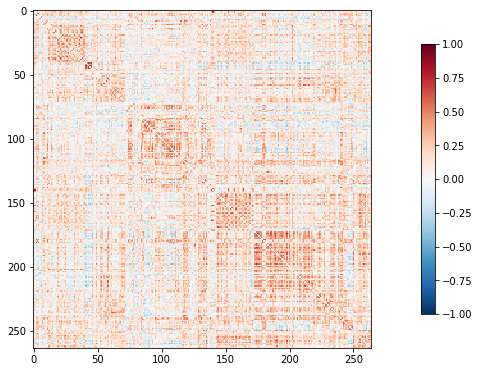

In [10]:
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(fc_power, 0)

# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation

#fc_power = np.arctanh(fc_power)
fc_power
plotting.plot_matrix(fc_power, vmin = -1, vmax = 1)
#plotting.plot_matrix(fc_power)

(array([   22.,    48.,    60.,   130.,   224.,   338.,   500.,   748.,
         1160.,  1468.,  1954.,  2308.,  2974.,  3356.,  4174.,  4206.,
         4564.,  4580.,  4714.,  4504.,  4300.,  3956.,  3550.,  3342.,
         2750.,  2226.,  1888.,  1576.,  1176.,   894.,   708.,   468.,
          342.,   216.,   104.,    72.,    54.,    22.,    12.,     8.]),
 array([-0.44483833, -0.41397204, -0.38310576, -0.35223948, -0.32137319,
        -0.29050691, -0.25964062, -0.22877434, -0.19790805, -0.16704177,
        -0.13617548, -0.1053092 , -0.07444291, -0.04357663, -0.01271034,
         0.01815594,  0.04902223,  0.07988851,  0.1107548 ,  0.14162108,
         0.17248737,  0.20335365,  0.23421994,  0.26508622,  0.29595251,
         0.32681879,  0.35768508,  0.38855136,  0.41941765,  0.45028393,
         0.48115021,  0.5120165 ,  0.54288278,  0.57374907,  0.60461535,
         0.63548164,  0.66634792,  0.69721421,  0.72808049,  0.75894678,
         0.78981306]),
 <a list of 40 Patch objects>)

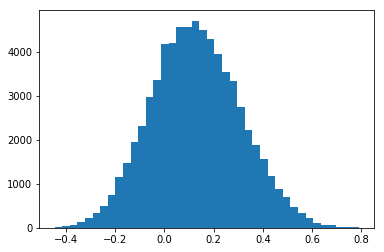

In [121]:
plt.hist(np.ravel(fc_power), bins = 40)

In [122]:
np.save("sub-01_denoising_acompcor_nilearn", fc_power)